In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Prepare data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=128, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('Number of training examples:', len(train_set))
print('Number of test examples:', len(test_set))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 50000
Number of test examples: 10000


In [3]:
def imshow(img):
    img = img / 2 + 0.5 # Un-normalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

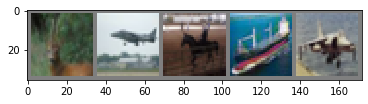

Labels: deer plane horse ship plane


In [4]:
# Show some random training images
NUM_IMAGES_TO_SHOW = 5
data_iter = iter(train_loader)
images, labels = data_iter.next()
imshow(torchvision.utils.make_grid(images[:NUM_IMAGES_TO_SHOW]))
print('Labels:', ' '.join(f'{classes[labels[i]]}' for i in range(NUM_IMAGES_TO_SHOW)))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.fc1 = nn.Linear(24 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #print('layer 0:', x.size())
        x = F.relu(self.conv1(x))
        #print('layer 1:', x.size())
        x = self.pool(x)
        #print('layer 2:', x.size())
        x = F.relu(self.conv2(x))
        #print('layer 3:', x.size())
        x = self.pool(x)
        #print('layer 4:', x.size())
        x = x.view(-1, 24 * 5 * 5)
        #print('layer 5:', x.size())
        x = F.relu(self.fc1(x))
        #print('layer 6:', x.size())
        x = F.relu(self.fc2(x))
        #print('layer 7:', x.size())
        x = self.fc3(x)
        #print('layer 8:', x.size())
        return x

In [6]:
# Create model
net = Net()
#device = 'cpu'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
print('Device:', device)

Device: cuda:0


In [7]:
# Create optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
print('Number of iterations per epoch:', len(train_loader))

Number of iterations per epoch: 391


In [9]:
# Train model
NUM_EPOCHS = 50
loss_per_epoch = np.zeros(NUM_EPOCHS)
accuracy_per_epoch = np.zeros(NUM_EPOCHS)
print('Starting training')
start_time = time.perf_counter()
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        predicted = torch.argmax(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch[epoch] += loss.item() / len(train_loader)
        accuracy_per_epoch[epoch] += (predicted == labels).sum().item() / len(train_set)
    # Print statistics
    print('Epoch [{}/{}] loss: {:.5f} accuracy: {:.2f}%'.format(
        epoch, NUM_EPOCHS - 1, loss_per_epoch[epoch], 100 * accuracy_per_epoch[epoch]))
elapsed_time = time.perf_counter() - start_time
print(f'Finished training - elapsed_time: {elapsed_time:.0f} sec')

Starting training
Epoch [0/49] loss: 2.30145 accuracy: 10.44%
Epoch [1/49] loss: 2.29067 accuracy: 16.81%
Epoch [2/49] loss: 2.19717 accuracy: 22.10%
Epoch [3/49] loss: 1.98646 accuracy: 28.20%
Epoch [4/49] loss: 1.89049 accuracy: 31.65%
Epoch [5/49] loss: 1.78711 accuracy: 35.24%
Epoch [6/49] loss: 1.69159 accuracy: 38.46%
Epoch [7/49] loss: 1.61070 accuracy: 41.16%
Epoch [8/49] loss: 1.54872 accuracy: 43.36%
Epoch [9/49] loss: 1.49046 accuracy: 45.68%
Epoch [10/49] loss: 1.44773 accuracy: 47.31%
Epoch [11/49] loss: 1.41580 accuracy: 48.57%
Epoch [12/49] loss: 1.38647 accuracy: 49.70%
Epoch [13/49] loss: 1.35563 accuracy: 51.04%
Epoch [14/49] loss: 1.33018 accuracy: 52.02%
Epoch [15/49] loss: 1.30465 accuracy: 53.00%
Epoch [16/49] loss: 1.28018 accuracy: 54.06%
Epoch [17/49] loss: 1.25472 accuracy: 55.01%
Epoch [18/49] loss: 1.22995 accuracy: 56.11%
Epoch [19/49] loss: 1.20266 accuracy: 57.22%
Epoch [20/49] loss: 1.18357 accuracy: 58.03%
Epoch [21/49] loss: 1.16059 accuracy: 58.92%
Ep

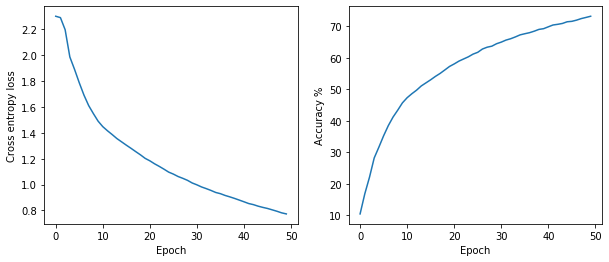

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(np.arange(NUM_EPOCHS), loss_per_epoch)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Cross entropy loss')
ax[1].plot(np.arange(NUM_EPOCHS), 100* accuracy_per_epoch)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy %')
plt.show()

In [28]:
# Save trained model
save_path = './nn_cifar10.pth'
torch.save(net.state_dict(), save_path)

FileNotFoundError: [Errno 2] No such file or directory: './saved_models/nn_cifar10.pth'

In [23]:
# Load trained model (obviously not necessary if you run the whole notebook)
net = Net()
net.load_state_dict(torch.load(save_path))
net.to(device)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

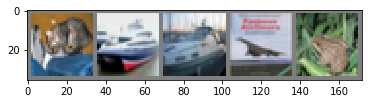

Labels: cat ship ship plane frog


In [24]:
# Show some test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
imshow(torchvision.utils.make_grid(images[:NUM_IMAGES_TO_SHOW]))
print('Labels:', ' '.join(f'{classes[labels[i]]}' for i in range(NUM_IMAGES_TO_SHOW)))

In [25]:
# Predict classes for the random test images
outputs = net(images.to(device))
predicted = torch.argmax(outputs, 1)
print('Predicted:', ' '.join(f'{classes[predicted[i]]}' for i in range(NUM_IMAGES_TO_SHOW)))

Predicted: truck truck truck truck truck


In [26]:
# Check the accuracy on the test set
num_total = len(test_set)
num_correct = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        predicted = torch.argmax(outputs.data, 1)
        num_correct += (predicted == labels).sum().item()
print(f'Accuracy of the model on the {num_total} test images: {100 * num_correct / num_total}%')

Accuracy of the model on the 10000 test images: 9.48%


In [27]:
# Check the accuracy per class
class_correct = np.zeros(len(classes))
class_total = np.zeros(len(classes))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        predicted = torch.argmax(outputs, 1)
        predicted_correct = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += predicted_correct[i].item()
            class_total[label] += 1
for i in range(len(classes)):
    print('Accuracy of {}: [{:.0f}/{:.0f}] {:.1f}%'.format(
        classes[i], class_correct[i], class_total[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: [0/1000] 0.0%
Accuracy of car: [0/1000] 0.0%
Accuracy of bird: [0/1000] 0.0%
Accuracy of cat: [0/1000] 0.0%
Accuracy of deer: [36/1000] 3.6%
Accuracy of dog: [0/1000] 0.0%
Accuracy of frog: [0/1000] 0.0%
Accuracy of horse: [0/1000] 0.0%
Accuracy of ship: [0/1000] 0.0%
Accuracy of truck: [912/1000] 91.2%
